In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.stats import chi2_contingency, ttest_ind, ttest_rel, f_oneway
%matplotlib inline
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
rc('pdf', fonttype=42)

In [52]:
def contingency_table(df_review, columns=[]):
    tab = pd.crosstab(df_review['model_attr'], df_review['user_attr'], margins=True)
    if len(columns)>0:
        tab = tab[columns]
    # print(tab.to_latex())
    print('contingency table')
    display(tab)
    tab = df_review.groupby(['model_attr', 'user_attr'])['rating'].size().unstack()
    if len(columns)>1:
        tab = tab[columns[:-1]]
    g, p, dof, expctd = chi2_contingency(tab.values)
    print('chi2', g.round(3), 'p-value', p.round(3))
    print('')
    print('real market size - expcted market size')
    display((tab-expctd).round(2))
    

In [53]:
def chi2_test_by_year(df_review):
    chi, p, _, expctd = chi2_contingency(df_review.groupby(['model_attr', 'user_attr'])['rating'].size().unstack().values)
    chi1, p1, _, expctd1 = chi2_contingency(df_review.loc[
        df_review['timestamp'].apply(lambda x: x.year<=2014)].groupby([
        'model_attr', 'user_attr'])['rating'].size().unstack().values)
    chi2, p2, _, expctd2 = chi2_contingency(df_review.loc[
        df_review['timestamp'].apply(lambda x: x.year==2015)].groupby([
        'model_attr', 'user_attr'])['rating'].size().unstack().values)
    chi3, p3, _, expctd3 = chi2_contingency(df_review.loc[
        df_review['timestamp'].apply(lambda x: x.year==2016)].groupby([
        'model_attr', 'user_attr'])['rating'].size().unstack().values)
    chi4, p4, _, expctd4 = chi2_contingency(df_review.loc[
        df_review['timestamp'].apply(lambda x: x.year>=2017)].groupby([
        'model_attr', 'user_attr'])['rating'].size().unstack().values)
    df = pd.DataFrame(np.array([[chi, p, expctd.sum()],
                                [chi1, p1, expctd1.sum()],
                                [chi2, p2, expctd2.sum()],
                                [chi3, p3, expctd3.sum()],
                                [chi4, p4, expctd4.sum()],]), 
                      columns=['chi2', 'p-value', 'sum'],
                      index=['all', '<=2014', '2015', '2016', '>=2017'])
    #print(df.round(3).to_latex())
    display(df.round(3))

In [54]:
def two_way_anova(df_review, metric):
    test3 = sm.stats.anova_lm(ols(metric+' ~ model_attr*user_attr', data=df_review).fit()).values[:3,-2:]
    df = pd.DataFrame(test3, columns=['F-stat', 'p-value'], index=['product', 'user', 'product:user'])
    #print(df.round(3).to_latex())
    display(df.round(3))
    return df

In [55]:
def plot_avg_by_segment(df_review, metric, figsize, index=[], dataset='', dump=True):
    fig = plt.figure(figsize=figsize)
    group_rating = df_review.groupby(['user_attr', 'model_attr'])[metric].mean().unstack()
    group_std = 1.96*df_review.groupby(['user_attr', 'model_attr'])[metric].sem().unstack()
    if len(index)>0:
        group_rating = group_rating.loc[index]
    group_rating.index = group_rating.index.rename('user identity')
    group_rating.columns = group_rating.columns.rename('product image')
    text = []
    for ri in range(group_rating.shape[0]):
        row = []
        for ci in range(group_rating.shape[1]):
            row.append(str(group_rating.values[ri, ci].round(2))+'\n('+r'$\pm$'+str(group_std.values[ri, ci].round(2))+')')
        text.append(row)
    text = np.array(text)
    
    sns.heatmap(group_rating, annot=text, fmt='s', cmap="YlGnBu", annot_kws={"size": 13},
                cbar=False)
    if dump:
        fig.savefig('./plot/'+dataset+'_'+metric+'_heatmap.pdf', bbox_inches='tight')

In [56]:
def get_stats(df_review):
    stats = []
    ts = df_review['timestamp'].describe()
    first, last = ts['first'], ts['last']
    n_review, n_item, n_user = df_review.shape[0], df_review['item_id'].nunique(), df_review['user_id'].nunique()
    item_group = df_review.groupby('model_attr')['item_id'].nunique()
    _na = n_item - item_group.sum()
    item_group = item_group.to_dict()
    item_group['N/A'] = _na
    user_group = df_review.groupby('user_attr')['user_id'].nunique()
    _na = n_user - user_group.sum()
    user_group = user_group.to_dict()
    user_group['N/A'] = _na
    df_stats = pd.DataFrame([n_review, n_item, n_user, ts['first'], ts['last'], item_group, user_group], 
                            index=['#review', '#item', '#user', 'first', 'last', 'item_group', 'user_group'])
    return df_stats

# ModCloth

In [57]:
dataset = 'modcloth'

df_review = pd.read_csv('./data/df_'+dataset+'.csv')
df_review['timestamp'] = pd.to_datetime(df_review['timestamp'])
df_review['fit_score'] = 0.0
df_review['fit_score'].loc[df_review['fit'] == 'Just right'] = 1.0
df_review['fit_score'].loc[df_review['fit'].isna()] = None
df_review['timestamp'] = pd.to_datetime(df_review['timestamp'])
df_stats1 = get_stats(df_review)
df_stats1.columns = ['modcloth']

/home/mengting/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


## Product Selection vs. Marketing Bias (ModCloth)
### Chi2 test of contingency table

In [30]:
contingency_table(df_review, ['Small', 'Large', 'All'])

contingency table


user_attr,Small,Large,All
model_attr,,,
Small,31800,7038,38838
Small&Large,41361,11327,52688
All,73161,18365,91526


chi2 158.739 p-value 0.0

real market size - expcted market size


user_attr,Small,Large
model_attr,,
Small,754.98,-754.98
Small&Large,-754.98,754.98


In [31]:
chi2_test_by_year(df_review)

,chi2,p-value,sum
all,158.739,0.000,91526.0
<=2014,0.532,0.466,25383.0
2015,66.722,0.000,20241.0
2016,70.816,0.000,21239.0
>=2017,29.046,0.000,24663.0


## Consumer Satisfaction vs. Marketing Bias (ModCloth)
### 2-way ANOVA on rating score

,F-stat,p-value
product,171.914,0.0
user,46.312,0.0
product:user,30.685,0.0


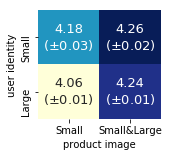

In [58]:
_ = two_way_anova(df_review, 'rating')
plot_avg_by_segment(df_review, 'rating', (2.2,2), ['Small', 'Large'], dataset, dump=False)

### 2-way ANOVA on clothing fit feedback

,F-stat,p-value
product,293.111,0.000
user,402.441,0.000
product:user,0.000,0.997


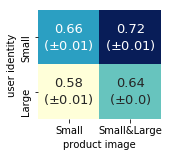

In [38]:
_ = two_way_anova(df_review, 'fit_score')
plot_avg_by_segment(df_review, 'fit_score', (2.2,2), ['Small', 'Large'], dataset, dump=False)

# Amazon Electronics

In [42]:
dataset = 'electronics'
df_review = pd.read_csv('./data/df_'+dataset+'.csv')
df_review['timestamp'] = pd.to_datetime(df_review['timestamp'])

## Product Selection vs. Marketing Bias (Electronics)
### Chi2 test of contingency table

In [47]:
contingency_table(df_review)

contingency table


user_attr,Female,Male,All
model_attr,,,
Female,34259,31587,65846
Female&Male,26478,24930,51408
Male,25963,30907,56870
All,86700,87424,174124


chi2 581.849 p-value 0.0

real market size - expcted market size


user_attr,Female,Male
model_attr,,
Female,1472.89,-1472.89
Female&Male,880.88,-880.88
Male,-2353.77,2353.77


## Consumer Satisfaction

,F-stat,p-value
product,62.581,0.000
user,3.508,0.061
product:user,0.907,0.404


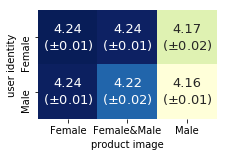

In [50]:
_ = two_way_anova(df_review, 'rating')
plot_avg_by_segment(df_review, 'rating', (3.2,2), [], dataset, dump=False)